# Ion Switching

This notebook analyses simulated patch-clamp electrophysiology data, with the goal of making a predictive model that can determine the number of open ion channels from the current signal. This is a competitive machine learning project hosted on Kaggle:

https://www.kaggle.com/c/liverpool-ion-switching/overview

The challenge is based on [this paper](https://www.nature.com/articles/s42003-019-0729-3) in which fake patch clamp data was used to train a deep learning model that was then successful at classifying real-world data (hand-labeled by electrophysiologists).

## What is Patch Clamp Electrophysiology?
![Patch Clamp](https://upload.wikimedia.org/wikipedia/en/7/7a/Cell-Attached_Patch_Clamp.png)
A patch pipette is attached to the cell membrane, and the electrical activty of that patch of the membrane is recorded. The membrane contains pores (ion channels) that can be open or closed. When they are open, they allow the passage of ions, and that movement of charge can be recorded as a current.

Image credit: https://en.wikipedia.org/wiki/Patch_clamp

In [65]:
import pandas as pd
import numpy as np
import sklearn
import random
from random import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns; sns.set(font_scale = 2)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

## Import and Describe Data

In [2]:
df_ts = pd.read_csv('open_channels.csv')
df_ts.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [5]:
df_ts.describe()

,time,signal,open_channels
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,2.500001e+02,1.386246e+00,2.726043e+00
std,1.443376e+02,3.336219e+00,2.665051e+00
min,1.000000e-04,-5.796500e+00,0.000000e+00
25%,1.250001e+02,-1.594800e+00,1.000000e+00
50%,2.500000e+02,1.124000e+00,2.000000e+00
75%,3.750000e+02,3.690100e+00,4.000000e+00
max,5.000000e+02,1.324400e+01,1.000000e+01


The training data includes a timestamp in seconds (in increments of 100 μs), a voltage signal, and a label indicating the number of open ion channels. There are 5 million samples, and we know from the project description on Kaggle that these 5 million samples are actually from 10 sets of 500,000 samples corresponding to discrete 50 s recordings. The current signal ranges from about -5.8 to +13.2 pA. The number of open channels ranges from 0 to 10.

## Plot Sample Data
It's useful to plot the raw data just to see what it looks like and the relationship between the signal and the number of open channels.

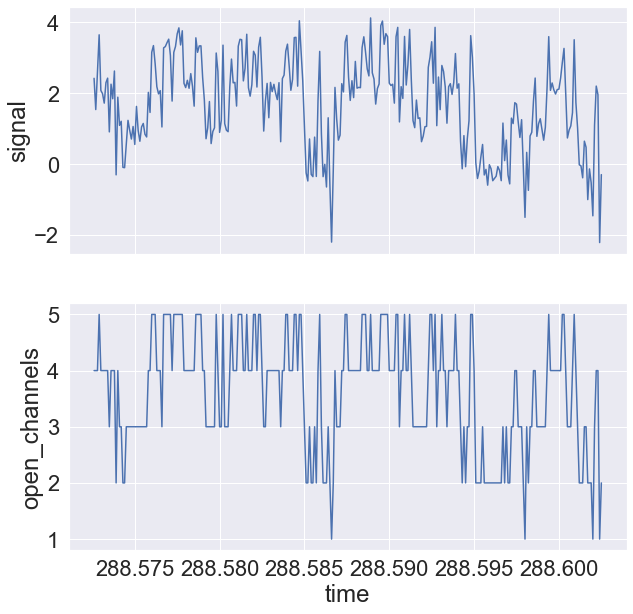

In [84]:
sns.set(font_scale = 2)
random.seed(1527)#1527
rnd_start = randint(0,4500000)
interval = 300
df_sample = df_ts[rnd_start : rnd_start + interval]
_, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.lineplot(x = 'time', y = 'signal', data = df_sample, ax = axes[0]);
sns.lineplot(x = 'time', y = 'open_channels', data = df_sample, ax = axes[1]);

We can see that **signal** and **open_channels** roughly track each other, with open_channels taking integer vales and signal being closer to zero and having negative values.

We can summarize the relationship between **signal** and **open_channels** with a violin plot:

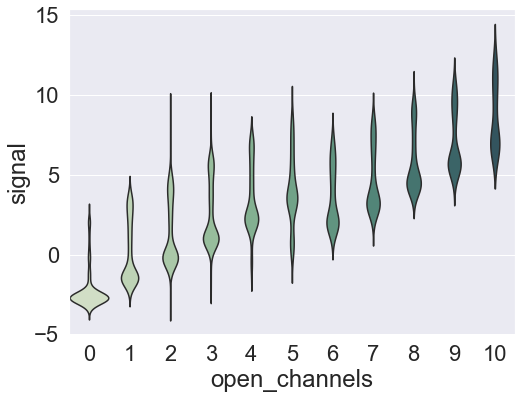

In [67]:
# Just get 0.1% of the data to pot
df_ts_sample = df_ts.sample(frac = 0.001)

# Use cubehelix to get a custom sequential palette
pal = sns.cubehelix_palette(11, rot=-.5, dark=.3)

# Show each distribution with both violins and points
fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(x='open_channels', y='signal', data = df_ts_sample, palette=pal, inner=None, ax=ax, width = 0.95);

From the violin plot, we can see that there is almost a linear relationship between **signal** and **open_channels**, though there is a discrepancy between 5 and 6 open channels. It also seems like the distribution of signal for each number of open channels is bimodal.

An important feature of this dataset is the fact that it is actually composed of 10 distinct recordsings in a row. If we make separate violin plots for each recording, we can see that the differences between recordings are quite significant.

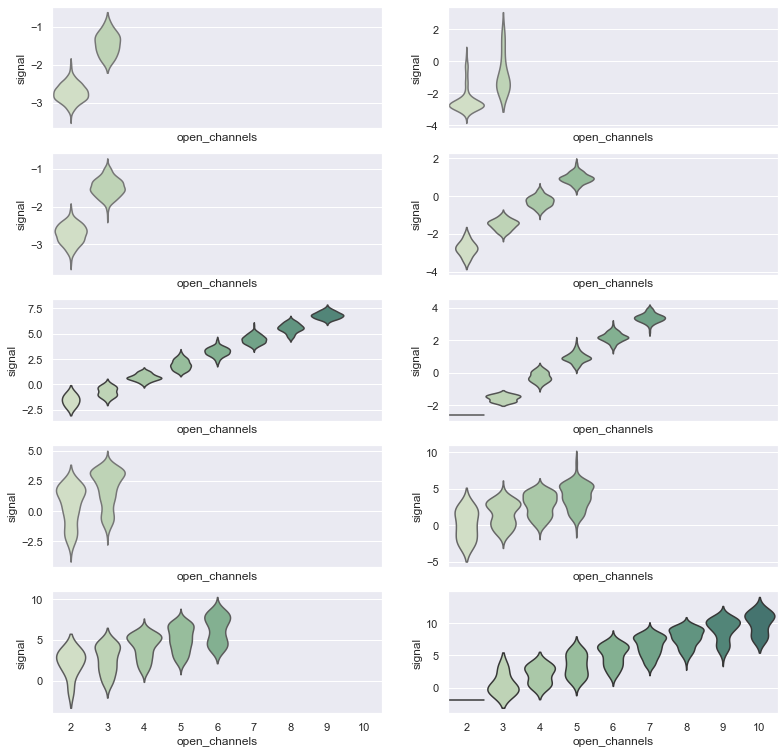

In [77]:
sns.set(font_scale = 1)
index = 0
f, axes = plt.subplots(5, 2, figsize=(13, 13), sharex=True)#,  sharey=True) #sharex=True,
df_ts_labeled = pd.DataFrame([])
for t in range(0, 5 * 10 ** 6, 5 * 10 ** 5):
    df_temp = df_ts[max(0, t - 1) : t - 1 + 5 * 10 ** 5]
    df_temp['tag'] = index + 1
    df_temp_sample = df_temp.sample(frac =0.001)
    df_ts_labeled = pd.concat([df_ts_labeled, df_temp_sample])
    sns.violinplot(x='open_channels', y='signal', data = df_temp_sample, palette=pal, inner=None, ax=axes[index//2, np.mod(index,2)], width = 0.95);
    #g.set(xlim = (0,10))
    index += 1

We can overlay these plots in a swarm plot:

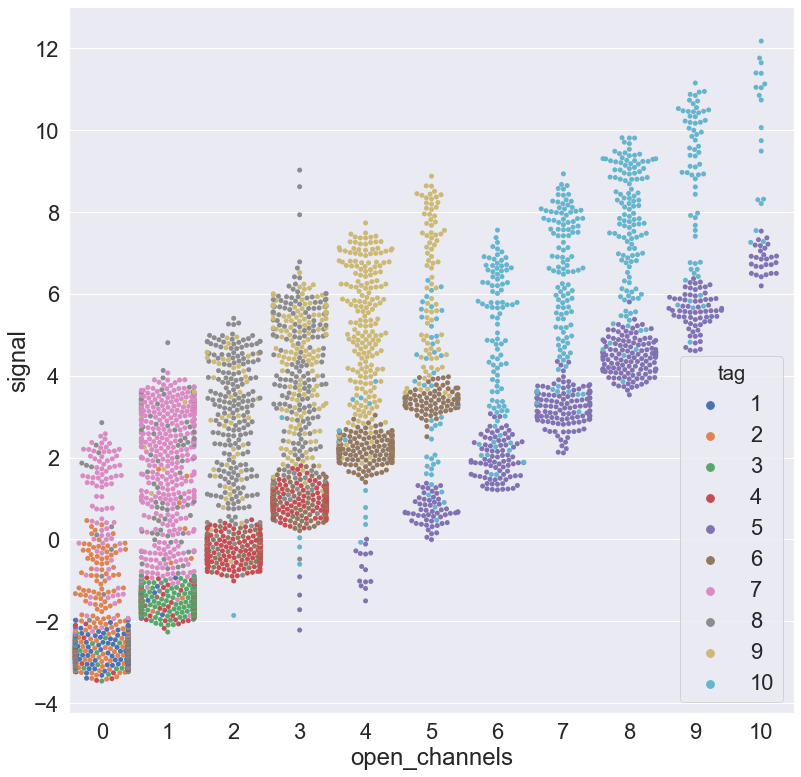

In [79]:
sns.set(font_scale = 2)
fig, ax = plt.subplots(figsize=(13,13))
sns.swarmplot(x="open_channels", y="signal", hue="tag", data=df_ts_labeled, ax = ax);

Here we can see a few things about the data. One is that for several of the datasets, there are two modes of signal for a given channel, and that the multiple modes come from different datasets. This will make separating them challenging. Additionally, there is a lot of heterogeneity in the range of open channels per dataset. For instance, only recordings 5 and 10 have signals corresponding to 6-10 channels. There are also several recordings that only have 0 or 1 open channels. Even among recordings that have a similar range of open channels, the amount of noise can be very different.

## Feature Engineering
Since the signal is composed of discrete values of current (corresponding to discrete numbers of open ion channels) plus noise, we want to de-noise the signal before predicting the number of open channels. Here we implement an exponentially weighted moving average filter with different weights to generate additional features for each data point. 

In [100]:
df_ts_w_features = pd.DataFrame([])
for t in range(0, 5 * 10 ** 6, 5 * 10 ** 5):
    df_temp = df_ts[max(0, t - 1) : t - 1 + 5 * 10 ** 5]
    avgs = [3, 10, 50, 100, 1000]
    for avg in avgs:
        avg_str = [str(avg) + '_avg']
        df_temp[avg_str] = df_temp[['signal']].ewm(span=avg).mean()
    vars = [5, 10, 100, 1000]
    for var in vars:
        avg_str = [str(var) + '_var']
        df_temp[avg_str] = df_temp[['signal']].ewm(span=var).var()
    df_ts_w_features = pd.concat([df_ts_w_features, df_temp])

df_ts_w_features = df_ts_w_features.fillna(0)
df_ts_w_features.head()

,time,signal,open_channels,3_avg,10_avg,50_avg,100_avg,1000_avg,5_var,10_var,100_var,1000_var
0,0.0001,-2.7600,0,-2.760000,-2.760000,-2.760000,-2.760000,-2.760000,0.000000,0.000000,0.000000,0.000000
1,0.0002,-2.8557,0,-2.823800,-2.812635,-2.808807,-2.808329,-2.807898,0.004579,0.004579,0.004579,0.004579
2,0.0003,-2.4074,0,-2.585857,-2.649733,-2.669618,-2.672004,-2.674131,0.068193,0.062073,0.056382,0.055807
3,0.0004,-3.1404,0,-2.881613,-2.811386,-2.794467,-2.792639,-2.791049,0.128486,0.109227,0.093156,0.091628
4,0.0005,-3.1525,0,-3.021426,-2.909311,-2.871914,-2.867519,-2.863628,0.106749,0.103608,0.095843,0.094860


Here the new features correspond to exponentially weighted moving averages computed using the pandas.DataFrame.ewm function, with varing parameters for the weighting function "span". For example, the feature **5_avg** is computed using a span of 5. A larger span means that previous values are weighted more heavily.

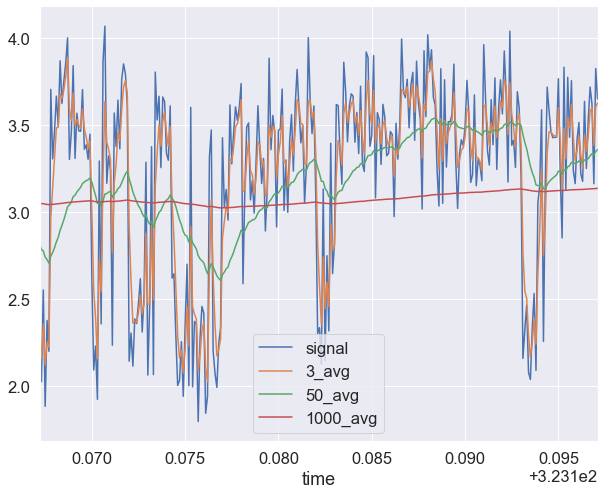

In [103]:
sns.set(font_scale = 1.5)
random.seed(0)
rnd_start = randint(0,4500000)
interval = 300
df_combined_sample = df_ts_w_features[rnd_start : rnd_start + interval]
df_plot_sample = df_combined_sample[['time','signal','3_avg','50_avg','1000_avg']]
_, ax = plt.subplots(figsize=(10,8))
df_plot_sample.plot(x='time', ax = ax);

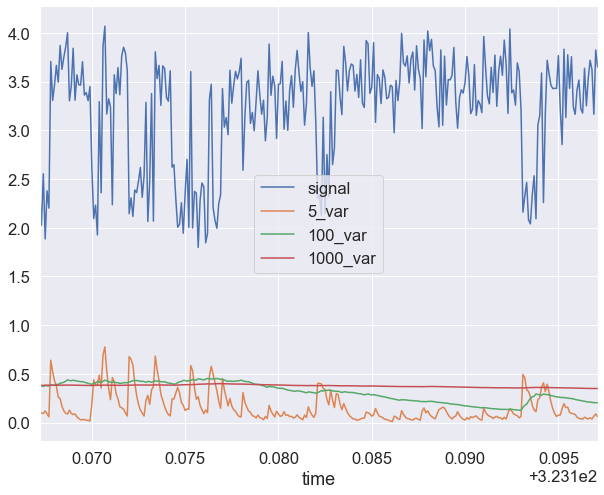

In [117]:
sns.set(font_scale = 1.5)
random.seed(0)
rnd_start = randint(0,4500000)
interval = 300
df_combined_sample = df_ts_w_features[rnd_start : rnd_start + interval]
df_plot_sample = df_combined_sample[['time','signal','5_var','100_var','1000_var']]
_, ax = plt.subplots(figsize=(10,8))
df_plot_sample.plot(x='time', ax = ax);

We can see that the moving averages are a smoothed version of the signal, with the largest span corresponding to a long-term average.

## Random Forest Classifier
Now that features de-noising the signal have been created, we can attempt to train a model that will then be able to classify the patch clamp current signal and determine how many ion channels are open based on the current. We will try a random forest model, and use a random search of hyperparameters to optimize.

In [104]:
# separate data in features and labels
data = df_ts_w_features[['signal','3_avg','10_avg','50_avg','100_avg','1000_avg','5_var','10_var','100_var','1000_var']]
labels = df_ts_w_features[['open_channels']]

# separate into train and test set
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=0)

# train random forest classifier
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

# # compute accuracy score
# rf.score(x_test, y_test)

# compute F1 score
predictions = rf.predict(x_test)
f1 = sklearn.metrics.f1_score(y_test, predictions, average = 'micro')
f1

0.9295304

The scikit-learn random forest classifier achieves 93% accuracy with no hyperparameter optimization. Let's check how the predictions compare to the labels in a random consecutive sequence of the training data.

## Plot Predictions vs. Labels

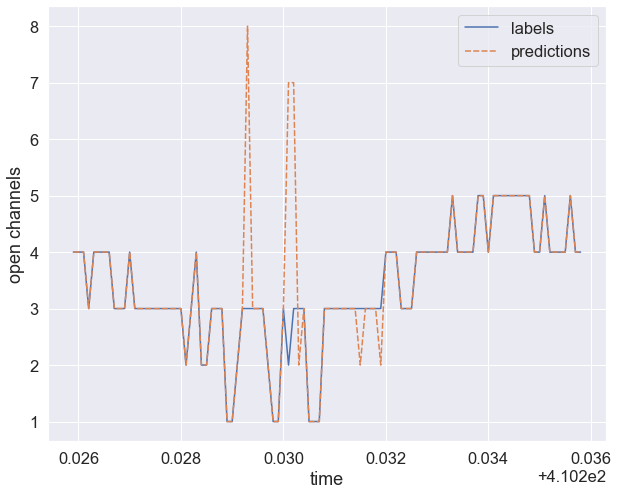

In [111]:
# choose a random time to start
random.seed(4201) # interesting: 23, 2211, 9211, 921, 9021, 901, 4201
interval = 100
t = random.randint(0, 5 * 10 ** 6 - interval)

# take a chunk of consecutive points in time
time = df_ts_w_features['time'][t : t + interval]
cons_sample_x = data[t : t + interval]
cons_sample_y = labels[t : t + interval].reset_index(drop=True).iloc[:,0]

predictions = rf.predict(cons_sample_x)

# combine time, labels, and predictions sample
plt_data = np.transpose(np.array([cons_sample_y, predictions])).reshape((100,2))
df_plt_data = pd.DataFrame(plt_data, np.transpose(np.array(time)), ['labels','predictions'])
df_plt_data.index.name = 'time'

# plot
_, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data= df_plt_data, ax = ax);
plt.ylabel('open channels');

## Confusion Matrix

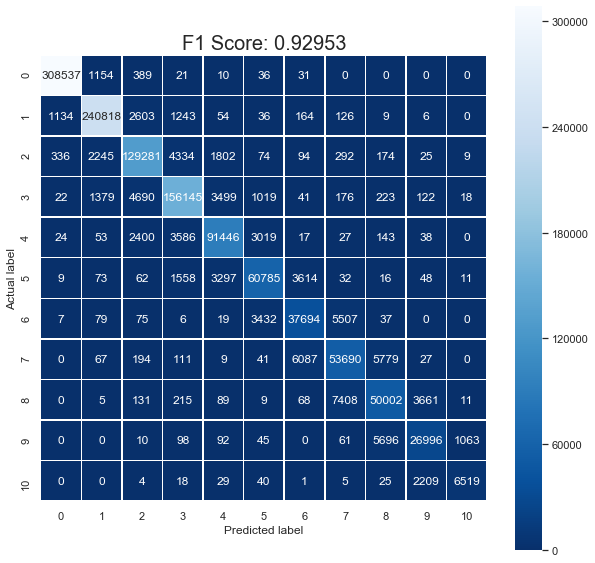

In [113]:
predictions = rf.predict(x_test)
cf = confusion_matrix(y_test, predictions)

con_mat = metrics.confusion_matrix(y_test, predictions)
sns.set(font_scale = 1)
plt.figure(figsize=(10,10))
ax = sns.heatmap(con_mat, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'F1 Score: {0:.5f}'.format(f1)
plt.title(all_sample_title, size = 20);
#ax = sns.heatmap(df_corr, annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

## Kaggle Submission
For scoring, there is a set of test data that has timestamps and signal columns only. The model has to generate predictions for each time point and a .csv file with columns for time and predctions was submitted. This model had an F1 score of 0.782 on the test data. This is likely due to the model being overfit on the training data. By constraining the hyperparameters of the random forest model, this overfitting could likely be reduced. A viable strategy to reduce overfitting might be to do cross-validation not on random subsets of the training data, but on the 10 different recordings that compose the training data.